dataset:

---

https://github.com/liaopeiyuan/artbench

# Experiments tried in this notebook:

Experiments here reference this chapter in the book:

https://colab.research.google.com/github/fastai/fastbook/blob/master/07_sizing_and_tta.ipynb


https://timm.fast.ai/RandomErase

**016. ) Random erasing**

Idea: Random erasing is one of the augmentation methods, where a random subset of image is replaced with random noise. How does training behave like with this method on its own, compared to best results obtained so far. Train in the similar way like experiment 013, change learning rate if needed.

Result: The method does not result in longer training. Results are slightly worse than 013, but comparable.

Conclusion: Random erasing could be used as augmentation method and is easy to implement. It would probably be better to try method on model that was already trained for couple of epochs to see how it behaves. Based on description this methods seems to be useful to make model robust to occlusion, which is not a problem here, since this are not scenes in natural enviroment.

**017. ) Mixup**

Idea: Following the description from Fastbook makes the methods seem very appropriate for this dataset:
> Mixup is a very powerful data augmentation technique that can provide dramatically higher accuracy, especially when you don't have much data and don't have a pretrained model that was trained on data similar to your dataset.


Use mixup data augmentation and train in the same way as experiment 013, change learning rate if needed.

Result: Training does not take longer, and results are a bit better than 016 and comparable to 013 and a bit worse on the validation set. What is interesting is the result on the train set; the loss is much higher than in experiments 013 and 016.

Conclusion: This method shows a lot of promise and should definitely be tried further. There are multiple options to try. One is training for even more epochs in a similar way, as the book states:

> Mixup requires far more epochs to train to get better accuracy, compared to other augmentation approaches we've seen.

Also, you could train a model for a couple of epochs normally and then continue training the model with this augmentation. Since so far this seems to be the most effective regularization method, it could also be tried when unfreezing the earlier layers.

# Import of libraries, creation of the experiment

In [ ]:
# mlflow dependencies
!pip install mlflow pyngrok --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 40.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 681.8/681.8 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.6/65.6 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.0/120.0 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.6/201.6 kB 12.1 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
# add flag force_remount=True if you changed or added util files
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# common utils for training functions
# change the path to google drive if elsewhere.
# this copies all of the utils file from drive to separate folder
# if this does not work you can always add functions manualy

import sys
if '/content/utils' not in sys.path:
  sys.path.insert(0, '/content/utils')

!cp -r '/content/drive/My Drive/Colab Notebooks/utils' '/content'

In [ ]:
# load mlflow.db from the google drive, so experiments will be present, but without any artifacts
!cp  /content/drive/My\ Drive/Colab\ Notebooks/mlflow_data/mlruns.db  /content/mlruns.db

In [ ]:
!ls '/content'

drive  mlruns.db  sample_data  utils


In [ ]:
from artworks_helpers import *
from fastai_utils import *
from mlflow_utils import *

In [ ]:
LOCAL_REGISTRY = "sqlite:///mlruns.db"
EXPERIMENT_NAME = "Artworks Classification"
MLFLOW_PORT = 5000

In [ ]:
mlfclient = create_mlflow_client(LOCAL_REGISTRY)

2025/08/10 19:38:36 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2025/08/10 19:38:36 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.


In [ ]:
experiment_tags = {
    "dataset": "artbench",
    "link": "https://github.com/liaopeiyuan/artbench",
}

In [ ]:
active_experiment_id = get_mlflow_experiment(mlfclient, EXPERIMENT_NAME, experiment_tags=experiment_tags)

In [ ]:
active_experiment_id

'1'

# Preparation of dataset

In [ ]:
from fastai.vision.all import *

In [ ]:
path = untar_data('https://artbench.eecs.berkeley.edu/files/artbench-10-imagefolder-split.tar')

# Preparation of dataloaders, model initalization with learning rate finder

In [ ]:
SPLIT_SEED = 42
VALID_PERCENTAGE = 0.2
BATCH_SIZE = 64

In [ ]:
RESNET18_PRETRAINED = 'resnet18_pretrained'
RESNET34_PRETRAINED = 'resnet34_pretrained'

**Default pictures, will be used for mixup**

In [ ]:
params_training_all_runs = {'data_split': 'random',
    'split_seed': SPLIT_SEED,
    'split_valid_pct': VALID_PERCENTAGE,
    'batch_tfms': 'Normalize.from_stats(*imagenet_stats)',
    'batch_size': BATCH_SIZE,
}

paintings = DataBlock(blocks = (ImageBlock, CategoryBlock),
                get_items=get_image_files,
                splitter=RandomSplitter(seed=SPLIT_SEED, valid_pct=VALID_PERCENTAGE),
                batch_tfms=[Normalize.from_stats(*imagenet_stats)],
                get_y=parent_label)

dls = paintings.dataloaders(path/"train", bs=BATCH_SIZE)

**Dataloaders with random erasing augmentation**

In [ ]:
params_training_all_runs = {'data_split': 'random',
    'split_seed': SPLIT_SEED,
    'split_valid_pct': VALID_PERCENTAGE,
    'batch_tfms': 'Normalize.from_stats(*imagenet_stats),  RandomErasing(p=0.5)',
    'batch_size': BATCH_SIZE,
}


paintings_random_erase = DataBlock(blocks = (ImageBlock, CategoryBlock),
                get_items=get_image_files,
                splitter=RandomSplitter(seed=SPLIT_SEED, valid_pct=VALID_PERCENTAGE),
                batch_tfms=[Normalize.from_stats(*imagenet_stats), RandomErasing(p=0.5)],
                get_y=parent_label)

dls = paintings_random_erase.dataloaders(path/"train", bs=BATCH_SIZE)

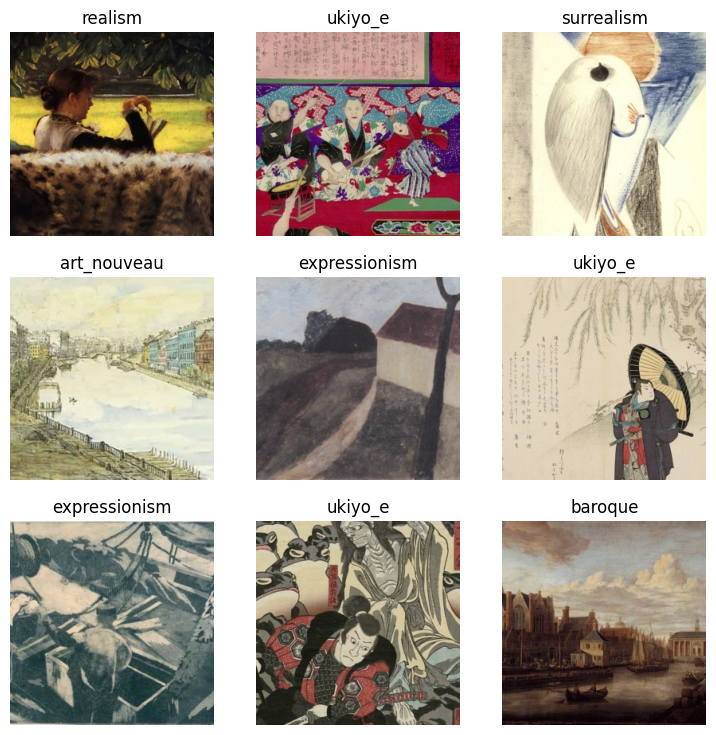

In [ ]:
dls.show_batch()

In [ ]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
params_training_all_runs['model_name'] = RESNET18_PRETRAINED

{'data_split': 'random', 'split_seed': 42, 'split_valid_pct': 0.2, 'batch_tfms': 'Normalize.from_stats(*imagenet_stats)', 'batch_size': 64, 'model_name': 'resnet18_pretrained'}

metric: slide,  learning_rate:  0.001000
learning rate following an interval slide rule, 
this could be when loss is decreasing just before the loss starts to increase rapidly

metric: valley,  learning_rate:  0.002089
learning rate from the longest valley, 
this could be before the loss starts to increase rapidly

metric: steep,  learning_rate:  0.004365
learning rate when the slope is the steepest, 
loss is decreasing most rapidly

metric: minimum,  learning_rate:  0.006918
1/10th of the minimum point for the loss function, 
largest sensible value to use for learning rate, since minimum is to high



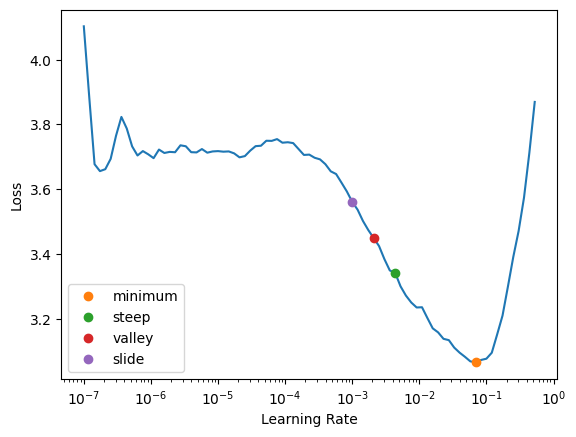

In [ ]:
learn_rate = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))
print(params_training_all_runs)
print()
format_lrs(learn_rate)

# Experiment

**016. ) Random erasing**

In [ ]:
with mlflow.start_run(experiment_id=active_experiment_id, run_name='016_random_erasing') as run:

    log_mlflow_params(mlfclient, run, params_training_all_runs)

    run_params = {"learning_rate": 0.005, 'num_epochs': 30, 'pct_start': 0.4, 'div':25, 'div_final':1e5}
    log_mlflow_params(mlfclient, run, run_params)

    cb_mlflow = MLFlowTracking(metric_names=['valid_loss', 'train_loss', 'error_rate'], client=mlfclient, run_id=run.info.run_id)

    learn.freeze()
    learn.fit_one_cycle(run_params['num_epochs'], lr_max=slice(run_params['learning_rate']), pct_start=run_params['pct_start'], div=run_params['div'], div_final=run_params['div_final'],
               cbs=[cb_mlflow, EarlyStoppingCallback(min_delta=0.001, patience=5)])

    save_fastai_model_as_artifact(mlfclient, run.info.run_id, learn, 'fastai_resnet18_train_only_frozen.pkl')

epoch,train_loss,valid_loss,error_rate,time
0,1.857467,1.418977,0.505000,02:08
1,1.587933,1.318216,0.481700,02:08
2,1.428613,1.269626,0.471100,02:07
3,1.368773,1.240001,0.463400,02:07
4,1.295096,1.221856,0.462900,02:06
5,1.297506,1.166350,0.436200,02:07
6,1.259732,1.160869,0.436800,02:06
7,1.225791,1.159990,0.431900,02:07
8,1.217024,1.132608,0.420700,02:09
9,1.212424,1.102813,0.411900,02:08


artifact_uri saved as model
runs:/0be73d1cb93e43b6af074b728f8974e6/fastai_model/fastai_resnet18_train_only_frozen.pkl


**017. ) Mixup**

In [ ]:
with mlflow.start_run(experiment_id=active_experiment_id, run_name='017_mixup') as run:

    log_mlflow_params(mlfclient, run, params_training_all_runs)

    run_params = {"learning_rate": 0.005, 'num_epochs': 30, 'pct_start': 0.4, 'div':25, 'div_final':1e5}
    log_mlflow_params(mlfclient, run, run_params)

    cb_mlflow = MLFlowTracking(metric_names=['valid_loss', 'train_loss', 'error_rate'], client=mlfclient, run_id=run.info.run_id)

    learn.freeze()
    learn.fit_one_cycle(run_params['num_epochs'], lr_max=slice(run_params['learning_rate']), pct_start=run_params['pct_start'], div=run_params['div'], div_final=run_params['div_final'],
               cbs=[cb_mlflow, EarlyStoppingCallback(min_delta=0.001, patience=5), MixUp()])

    save_fastai_model_as_artifact(mlfclient, run.info.run_id, learn, 'fastai_resnet18_train_only_frozen.pkl')

epoch,train_loss,valid_loss,error_rate,time
0,2.169264,1.431678,0.514600,02:08
1,1.797559,1.334841,0.482000,02:08
2,1.685383,1.306425,0.476900,02:09
3,1.645141,1.276718,0.464100,02:09
4,1.632569,1.262109,0.463200,02:08
5,1.591603,1.227763,0.451200,02:08
6,1.575818,1.204766,0.436100,02:09
7,1.556179,1.178879,0.424500,02:08
8,1.524160,1.161740,0.425200,02:08
9,1.515712,1.155254,0.421900,02:09


artifact_uri saved as model
runs:/7f13e161adfd42e3b5c368945f56916b/fastai_model/fastai_resnet18_train_only_frozen.pkl


**Saving of the model data**

In [ ]:
run = get_last_run_id(mlfclient, '1')

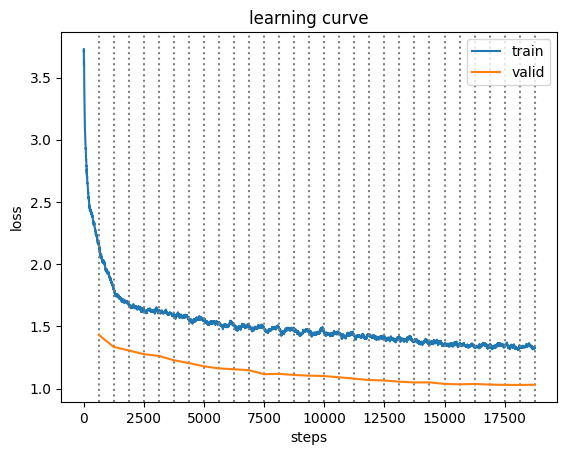

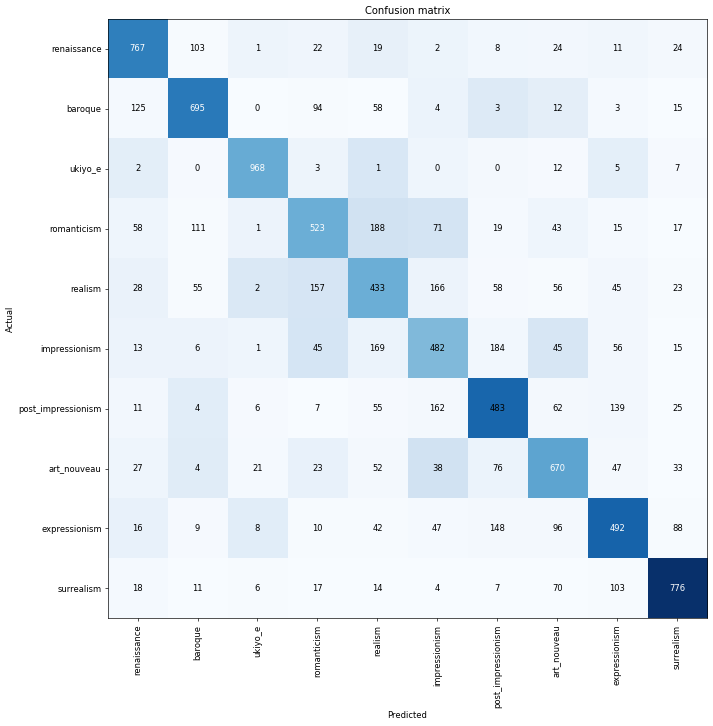

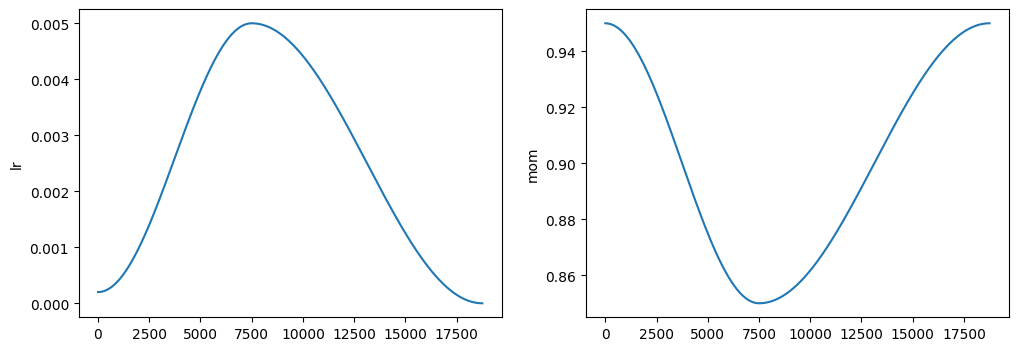

In [ ]:
interp = store_fastai_classification_recordings(learn, mlfclient, run, genres_sorted_era)

**Copy back to server**

In [ ]:
# copy mlflow mlruns.db back to server
!cp   /content/mlruns.db  /content/drive/My\ Drive/Colab\ Notebooks/mlflow_data/mlruns.db

# copy mlflow_data back to server
!cp -r /content/mlruns    /content/drive/My\ Drive/Colab\ Notebooks/mlflow_data

# Interpretation of the results

In [ ]:
interp.print_classification_report()

In [ ]:
def distance(list_of_elems, el1, el2):
  return abs(list_of_elems.index(el1) - list_of_elems.index(el2))


In [ ]:
distance_formula = partial(distance, genres_sorted_era)
confused_counts = interp.most_confused()

In [ ]:
for count in confused_counts:
    print((count[0], count[1],  distance_formula(count[0], count[1]), count[2]))

# Mlfow how to start server to view results in colab


In [ ]:
start_mlflow_server_in_collab(LOCAL_REGISTRY, MLFLOW_PORT)

In [ ]:
!ps x | grep '[m]lflow ui'

In [ ]:
 ngrok_access_to_mlflow_in_collab(MLFLOW_PORT)

With MLflow, you can resume a run that has ended. This is a useful feature for continuing training from a checkpoint or adding more information to an existing run.

You can resume a run by using the mlflow.start_run() function with the run_id of the ended run.